# Analisis stocks inversion

In [158]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from selenium import webdriver
#from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import time
import datetime
import os
import pickle

path = "F:\OneDrive - Universidad Católica de Santa María\Proyectos\Stock_analysis\msedgedriver.exe"
#web = "https://es.investing.com/equities/nvidia-corp-income-statement"
ls_web = ["https://es.investing.com/equities/ibm-income-statement","https://es.investing.com/equities/microsoft-corp-income-statement","https://es.investing.com/equities/google-inc-c-income-statement","https://es.investing.com/equities/amazon-com-inc-income-statement","https://es.investing.com/equities/oracle-corp-income-statement","https://es.investing.com/equities/sap-ag-ads-exch-income-statement"]
#ls_web = ["https://es.investing.com/equities/microsoft-corp-income-statement"]

#fig = go.Figure()
service = Service(executable_path=path)

In [159]:
lst_tickers = ["IBM", "MSFT", "GOOG", "AMZN", "ORCL", "SAP"]
start_date = '2023-09-01'
#end_date = '2022-12-31'
data_yf_stock = yf.download(lst_tickers, start_date, interval="1d")
data_yf_stock_close = data_yf_stock.loc[:,"Close"]

[*********************100%%**********************]  6 of 6 completed


In [160]:
class tp_stock(object):
    
    def __init__(self, df_resultados, df_balance, df_flujo_caja, df_dividendos):
        #Dataframe Resultados procesamiento
        self.df_resultados = df_resultados
        self.df_resultados = self.df_resultados[self.df_resultados.iloc[:,1].str.len() <= 20]
        self.df_resultados.set_index("Período terminado:", inplace=True)
        self.df_resultados = self.df_resultados.swapaxes('index', 'columns')
        self.df_resultados.index = self.df_resultados.index.str.replace('/', '')
        self.df_resultados.index = pd.to_datetime(self.df_resultados.index, format='%Y%d%m')
        self.df_resultados = self.df_resultados.replace(",", ".")
        self.df_resultados = self.df_resultados.replace("-", float("nan"))
        self.df_resultados = self.df_resultados.astype(float)
        self.df_resultados["Margen_bruto(%)"] =  ( self.df_resultados["Beneficio bruto"] / self.df_resultados["Ingresos totales"] ) * 100
        self.df_resultados["Margen_explotacion(%)"] =  ( self.df_resultados["Resultado de explotación"] / self.df_resultados["Ingresos totales"] ) * 100
        self.df_resultados["Margen_gnetas(%)"] =  ( self.df_resultados["Resultado del ejercicio"] / self.df_resultados["Ingresos totales"] ) * 100

        #Dataframe Balance procesamiento
        self.df_balance = df_balance
        self.df_balance = self.df_balance[self.df_balance.iloc[:,1].str.len() <= 20]
        self.df_balance.set_index("Período terminado:", inplace=True)
        self.df_balance = self.df_balance.swapaxes('index', 'columns')
        self.df_balance.index = self.df_balance.index.str.replace('/', '')
        self.df_balance.index = pd.to_datetime(self.df_balance.index, format='%Y%d%m')
        self.df_balance = self.df_balance.replace(",", ".")
        self.df_balance= self.df_balance.replace("-", float("nan"))
        self.df_balance = self.df_balance.astype(float)
        self.df_balance["Ratio solvencia"] =  ( self.df_balance["Total activos"] / self.df_balance["Total pasivo"] )
        self.df_balance["Ratio liquidez"] =  ( self.df_balance["Total activos corrientes"] / self.df_balance["Total pasivo corriente"] )
        self.df_balance["Endeudamiento a largo plazo"] =  ( ( self.df_balance["Total pasivo"] - self.df_balance["Total pasivo corriente"] ) / self.df_balance["Total activos"] )
        self.df_balance["Ratio endeudamiento total"] =  ( self.df_balance["Total pasivo"] / self.df_balance["Total activos"] )

        #Dataframe Flujo de caja procesamiento
        self.df_flujo_caja = df_flujo_caja
        self.df_flujo_caja.columns = [r_colum[0] for r_colum in self.df_flujo_caja.columns]
        self.df_flujo_caja = self.df_flujo_caja[self.df_flujo_caja.iloc[:,1].str.len() <= 20]
        self.df_flujo_caja.set_index("Período terminado:", inplace=True)
        self.df_flujo_caja = self.df_flujo_caja.swapaxes('index', 'columns')
        self.df_flujo_caja.index = self.df_flujo_caja.index.str.replace('/', '')
        self.df_flujo_caja.index = pd.to_datetime(self.df_flujo_caja.index, format='%Y%d%m')
        self.df_flujo_caja = self.df_flujo_caja.replace(",", ".")
        self.df_flujo_caja = self.df_flujo_caja.replace("-", float("nan"))
        self.df_flujo_caja = self.df_flujo_caja.astype(float)

        #Dataframe Dividendos procesamiento
        self.df_dividendos = df_dividendos
        self.df_dividendos["Fecha de pago"] = pd.to_datetime(self.df_dividendos["Fecha de pago"] , format='%d.%m.%Y')
        self.df_dividendos["Rendimiento"] = self.df_dividendos["Rendimiento"].str.replace(',', '.')
        self.df_dividendos["Rendimiento"] = self.df_dividendos["Rendimiento"].str.replace('%', '')
        self.df_dividendos["Rendimiento"] = self.df_dividendos["Rendimiento"].replace("-", float("nan"))
        self.df_dividendos["Rendimiento"] = self.df_dividendos["Rendimiento"].astype(float)


    def graph_resultados(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=self.df_resultados.index, y= self.df_resultados["Ingresos"], mode='lines+markers'))
        fig.update_layout(title='Ingresos vs Período terminado', xaxis_title='Período terminado', yaxis_title='Ingresos')
        fig.show()

    def graph_balance(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=self.df_balance.index, y= self.df_balance["Total pasivo"], mode='lines+markers'))
        fig.update_layout(title='Pasivos vs Período terminado', xaxis_title='Período terminado', yaxis_title='Pasivos')
        fig.show()

    def graph_flujo_caja(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=self.df_flujo_caja.index, y= self.df_flujo_caja["Resultado consolidado del ejercicio"], mode='lines+markers'))
        fig.update_layout(title='Resultado del ejercicio vs Período terminado', xaxis_title='Período terminado', yaxis_title='Resultado del ejercicio')
        fig.show()

    def graph_dividendos(self):
        fig = go.Figure()
        #self.df_dividendos["Rendimiento"] = self.df_dividendos["Rendimiento"].str.rstrip('%').str.replace(',', '.').astype(float)
        fig.add_trace(go.Scatter(x=self.df_dividendos["Fecha de pago"], y= self.df_dividendos["Rendimiento"], mode='lines+markers'))
        fig.update_layout(title='Rendimiento vs Fecha de pago', xaxis_title='Fecha de pago', yaxis_title='Rendimiento')
        fig.show()

In [161]:

def graph_stock_tecnico (name_stock,start_date, int_desv):
    data_yf_stock = yf.download(name_stock, start_date)
    data_yf_stock = data_yf_stock.loc[:,["Close"]].copy()
    data_yf_stock["Media"] = data_yf_stock["Close"].rolling(window=20).mean()
    data_yf_stock["Desv"] = data_yf_stock["Close"].rolling(window=20).std()
    data_yf_stock["Upper_band"] = data_yf_stock["Media"] + (data_yf_stock["Desv"] * int_desv)
    data_yf_stock["Lower_band"] = data_yf_stock["Media"] - (data_yf_stock["Desv"] * int_desv)
    #data_yf_stock_close.dropna(inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data_yf_stock.index, y= data_yf_stock["Close"], mode='lines+markers', name = name_stock))
    fig.add_trace(go.Scatter(x=data_yf_stock.index, y= data_yf_stock["Media"], mode='lines', name = "Media"))
    fig.add_trace(go.Scatter(x=data_yf_stock.index, y= data_yf_stock["Upper_band"], mode='lines', name = "Upper band Bollinger"))
    fig.add_trace(go.Scatter(x=data_yf_stock.index, y= data_yf_stock["Lower_band"], mode='lines', name = "Lower band Bollinger"))
    fig.update_layout(title='Precio de ' + name_stock, xaxis_title='Fecha', yaxis_title='Precio')
    #fig.update_layout(shapes=[dict(type="rect", xref="x", yref="y", x0=data_yf_stock_close.iloc[0], x1=data_yf_stock_close.iloc[-1], y0=data_yf_stock_close["Lower_band"].min(), y1=data_yf_stock_close["Upper_band"].max(), fillcolor="rgba(0,0,255,0.1)", layer="below", line=dict(width=0))])
    fig.show()

def graph_stock_tecnico_var (name_stock,start_date, int_desv):
    data_yf_stock = yf.download(name_stock, start_date)
    data_yf_stock_highlow = data_yf_stock.loc[:,["High","Low"]].copy()
    data_yf_stock_highlow= data_yf_stock_highlow.stack()
    data_yf_stock_highlow = data_yf_stock_highlow.reset_index()
    data_yf_stock_highlow.columns = ["Date","Time","Price"]
    data_yf_stock_highlow["Media"] = data_yf_stock_highlow["Price"].rolling(window=20).mean()
    data_yf_stock_highlow["Desv"] = data_yf_stock_highlow["Price"].rolling(window=20).std()
    data_yf_stock_highlow["Upper_band"] = data_yf_stock_highlow["Media"] + (data_yf_stock_highlow["Desv"] * int_desv)
    data_yf_stock_highlow["Lower_band"] = data_yf_stock_highlow["Media"] - (data_yf_stock_highlow["Desv"] * int_desv)
    #data_yf_stock_close.dropna(inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data_yf_stock_highlow["Date"], y= data_yf_stock_highlow["Price"], mode='lines+markers', name = name_stock))
    fig.add_trace(go.Scatter(x=data_yf_stock_highlow["Date"], y= data_yf_stock_highlow["Media"], mode='lines', name = "Media"))
    fig.add_trace(go.Scatter(x=data_yf_stock_highlow["Date"], y= data_yf_stock_highlow["Upper_band"], mode='lines', name = "Upper band Bollinger"))
    fig.add_trace(go.Scatter(x=data_yf_stock_highlow["Date"], y= data_yf_stock_highlow["Lower_band"], mode='lines', name = "Lower band Bollinger"))
    fig.update_layout(title='Precio de ' + name_stock, xaxis_title='Fecha', yaxis_title='Precio')
    #fig.update_layout(shapes=[dict(type="rect", xref="x", yref="y", x0=data_yf_stock_close.iloc[0], x1=data_yf_stock_close.iloc[-1], y0=data_yf_stock_close["Lower_band"].min(), y1=data_yf_stock_close["Upper_band"].max(), fillcolor="rgba(0,0,255,0.1)", layer="below", line=dict(width=0))])
    fig.show()

    

In [187]:
driver = webdriver.Edge(service=service)
wait = WebDriverWait(driver, 60)
wait_6 = WebDriverWait(driver, 6)
driver.maximize_window()
dic_stocks = {}

for web in ls_web:

    driver.get(web)
    name_stock = wait.until(EC.presence_of_element_located((By.XPATH, "//h1[@itemprop='name']"))).text
    
    #Tabla Resultados Stock
    wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='alignBottom']/div/a[@data-ptype='Annual']"))).click()
    html_resultados = wait.until(EC.presence_of_element_located((By.XPATH, "(//table[@class='genTbl reportTbl'])[1]"))).get_attribute("outerHTML")
    df_resultados = pd.read_html(html_resultados, flavor="html5lib",  thousands='.', decimal=',')[0]
    
    #Tabla Balance Stock
    wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Balance')]"))).click()
    wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='alignBottom']/div/a[@data-ptype='Annual']"))).click()
    html_balance = wait.until(EC.presence_of_element_located((By.XPATH, "(//table[@class='genTbl reportTbl'])[1]"))).get_attribute("outerHTML")
    df_balance = pd.read_html(html_balance, flavor="html5lib", thousands='.', decimal=',')[0]
    
    #Tabla Flujo de caja
    try:
        wait_6.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Flujo de caja')]"))).click()
    except:
        wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Cash Flow')]"))).click()
    wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='alignBottom']/div/a[@data-ptype='Annual']"))).click()
    html_flujo_caja = wait.until(EC.presence_of_element_located((By.XPATH, "(//table[@class='genTbl reportTbl'])[1]"))).get_attribute("outerHTML")
    df_flujo_caja = pd.read_html(html_flujo_caja, flavor="html5lib",  thousands='.', decimal=',')[0]
    
    #Tabla Dividendos
    try:
        try:
            wait_6.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Dividendos')]"))).click()
        except:
            wait_6.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Dividends')]"))).click()
        try:
            try:
                wait_6.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Mostrar más')]"))).click()
            except:
                wait_6.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Show more')]"))).click()
        except:
            pass
        time.sleep(4)
        html_dividendos = wait_6.until(EC.presence_of_element_located((By.XPATH, "//table[starts-with(@id,'dividendsHistoryData')]"))).get_attribute("outerHTML")
        df_dividendos = pd.read_html(html_dividendos, flavor="html5lib", converters={"Dividendo":str}, decimal=',')[0]
        df_dividendos = df_dividendos[["Fecha de pago", "Rendimiento"]]
    except:
        df_dividendos = pd.DataFrame(columns = ["Fecha de pago", "Rendimiento"])

    stock = tp_stock(df_resultados, df_balance, df_flujo_caja, df_dividendos)
    dic_stocks[name_stock] = stock
    
driver.quit()

In [188]:
#Muestra el precio de las acciones consultadas con sus tickets en YahooFinance
fig = make_subplots(rows=6, cols=1, shared_xaxes=True, subplot_titles=list(data_yf_stock_close.columns), vertical_spacing = 0.03)
for row, ticker_stock in enumerate(list(data_yf_stock_close.columns)):
    fig.add_trace(go.Scatter(x=data_yf_stock_close.index , y=data_yf_stock_close[ticker_stock], name=ticker_stock), row=row+1, col=1)
#+fig.update_layout(title='Precio de acciones AMZN', xaxis_title='Fecha', yaxis_title='Precio')
fig.update_layout(height=3000, width=1800)
fig.show()

In [189]:
#Definimos la accion especifica a analizar con su ticket utilizando las funciones previamente definidas utilizando Yahoo Finance
name_stock = "SAP.DE"
graph_stock_tecnico(name_stock,'2023-09-01',2) 
graph_stock_tecnico_var(name_stock,'2023-09-01',2)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [190]:
#Guardamos la clase Stock en un archivo PKL
with open('dic_stocks.pkl', 'wb') as archivo_pickle:
    pickle.dump(dic_stocks, archivo_pickle)

In [191]:
#Abrimos el archivo PKL con el objeto Stock que tiene almacenado las acciones
with open('dic_stocks.pkl', 'rb') as archivo_pickle:
    # Cargar el diccionario desde el archivo usando pickle
    dic_stocks_pkl = pickle.load(archivo_pickle)
print(dic_stocks_pkl.keys())

dict_keys(['International Business Machines (IBM)', 'Microsoft Corporation (MSFT)', 'Alphabet Inc Class C (GOOG)', 'Amazon.com Inc (AMZN)', 'Oracle Corporation (ORCL)', 'SAP SE ADR (SAP)'])


In [193]:
# Definimos la accion del objeto para acceder a los reportes
stock_pk0 = list(dic_stocks_pkl.keys())[1]
dic_stocks_pkl[stock_pk0].df_resultados

Período terminado:,Ingresos totales,Ingresos,Otros ingresos de explotación,Consumos y otros gastos externos,Beneficio bruto,Total gastos de explotación,Gastos de personal,Investigación y desarrollo,Amortizaciones,Gastos financieros (ingresos) - Neto de Operaciones,...,Resultado procedente de las operaciones continuadas (neto de minoritarios),Ajuste del resultado,Resultado del ejercicio,Resultado promedio ponderado por acción,Beneficio por acción del periodo,Dividendo por acción,UPA - Utilidades por acción,Margen_bruto(%),Margen_explotacion(%),Margen_gnetas(%)
2023-06-30,211915.0,211915.0,NaN,65711.0,146204.0,122440.0,29534.0,27195.0,13861.0,-1995.0,...,72361.0,32.04,72328.96,7472.0,9.68,2.72,7.53,68.991813,42.222117,34.131119
2022-06-30,198270.0,198270.0,NaN,62650.0,135620.0,114887.0,27725.0,24512.0,NaN,-2047.0,...,72738.0,-23.00,72761.00,7540.0,9.65,2.48,6.90,68.401674,42.055278,36.697937
2021-06-30,168088.0,168088.0,NaN,52232.0,115856.0,98172.0,25224.0,20716.0,NaN,-2330.0,...,61271.0,26.60,61244.40,7608.0,8.05,2.24,5.74,68.925801,41.594879,36.435915
2020-06-30,143015.0,143015.0,NaN,46078.0,96937.0,90189.0,24709.0,19269.0,NaN,NaN,...,44281.0,NaN,44281.00,7683.0,5.76,1.99,5.80,67.781002,36.937384,30.962486


In [194]:
dic_stocks_pkl[stock_pk0].df_balance

Período terminado:,Total activos corrientes,Efectivo y inversiones a corto plazo,Tesorería,Efectivo y equivalentes,Inversiones a corto plazo,Deudores comerciales y otras cuentas corrientes a cobrar,Deudores comerciales y otras cuentas a cobrar,Existencias,Pagos por adelantado,Otros activos corrientes,...,ESOP Acciones a empleados,Ganancia (Pérdida) acumuladas,Diferencias de conversión,Total pasivo y patrimonio neto,Acciones comunes en circulación,Accciones preferidas en circulación,Ratio solvencia,Ratio liquidez,Endeudamiento a largo plazo,Ratio endeudamiento total
2023-06-30,184257.0,111256.0,NaN,34704.0,76552.0,57888.0,48688.0,2500.0,NaN,12613.0,...,NaN,NaN,-6343.0,411976.0,7432.0,NaN,2.002284,1.769167,0.246626,0.499430
2022-06-30,169684.0,104749.0,NaN,13931.0,90818.0,50361.0,44261.0,3742.0,NaN,10832.0,...,NaN,NaN,-4678.0,364840.0,7464.0,NaN,1.839857,1.784607,0.282908,0.543520
2021-06-30,184406.0,130256.0,NaN,14224.0,116032.0,38043.0,38043.0,2636.0,NaN,13471.0,...,NaN,3222.0,1822.0,333779.0,7519.0,NaN,1.740327,2.079994,0.308989,0.574605
2020-06-30,181915.0,136527.0,NaN,13576.0,122951.0,32011.0,32011.0,1895.0,NaN,11482.0,...,NaN,5478.0,-2292.0,301311.0,7571.0,NaN,1.646445,2.515765,0.367385,0.607369


In [195]:
dic_stocks_pkl[stock_pk0].df_flujo_caja

Período terminado:,Resultado consolidado del ejercicio,Flujos de efectivo de las actividades de explotación,Depreciación,Amortización,Impuestos diferidos,Otros ajustes,Ingresos en efectivo,Pagos en efectivo,Cobros y (pagos) por impuestos sobre beneficios,Pago de intereses,...,Distribución de dividendos,Adquisición de instrumentos de capital propio,Pasivos subordinados,Efecto de las variaciones de los tipos de cambio,Variación neta del efectivo y equivalentes,Saldo de efectivo a la apertura,Saldo de efectivo al cierre,Flujo de caja libre,Crecimiento del flujo de caja libre,Rendimiento del flujo de caja libre
2023-06-30,72361.0,87582.0,11000.0,2500.0,-6059.0,4109.0,NaN,NaN,23100.0,1700.0,...,-19800.0,-20379.0,-2750.0,169.0,20773.0,13931.0,34704.0,47864.00,-3.26,2.35
2022-06-30,72738.0,89035.0,12600.0,2000.0,-5702.0,1251.0,NaN,NaN,16000.0,1900.0,...,-18135.0,-30855.0,-9023.0,232.0,-293.0,14224.0,13931.0,49479.00,19.70,3.38
2021-06-30,61271.0,76740.0,10900.0,1600.0,-150.0,5505.0,NaN,NaN,13400.0,2000.0,...,-16521.0,-25692.0,-3750.0,133.0,648.0,13576.0,14224.0,41337.25,20.66,2.74
2020-06-30,44281.0,60675.0,12796.0,NaN,11.0,5070.0,NaN,NaN,12500.0,2400.0,...,-15137.0,-21625.0,-5518.0,-201.0,2220.0,NaN,NaN,NaN,NaN,NaN


In [196]:
dic_stocks_pkl[stock_pk0].df_dividendos

,Fecha de pago,Rendimiento
0,2024-03-14,0.74
1,2023-12-14,0.81
2,2023-09-14,0.85
3,2023-06-08,0.87
4,2023-03-09,1.00
5,2022-12-08,1.12
6,2022-09-08,0.85
7,2022-06-09,0.93
8,2022-03-10,0.83
9,2021-12-09,0.73


In [197]:
# Comparamos los principales indicadores de las acciones que pertenecen al grupo de BI
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_resultados.index , y=dic_stocks_pkl[stock_pkl].df_resultados["Margen_bruto(%)"], name=stock_pkl))
fig.update_layout(title='Margen bruto de las acciones', xaxis_title='Periodo terminado', yaxis_title="Margen_bruto(%)")
fig.show()

In [198]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_resultados.index , y=dic_stocks_pkl[stock_pkl].df_resultados["Margen_explotacion(%)"], name=stock_pkl))
fig.update_layout(title='Margen explotacion de acciones (%)', xaxis_title='Periodo terminado', yaxis_title="Margen explotacion (%)")
fig.show()

In [199]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_resultados.index , y=dic_stocks_pkl[stock_pkl].df_resultados["Margen_gnetas(%)"], name=stock_pkl))
fig.update_layout(title='Margen de ganancias netas de acciones', xaxis_title='Periodo terminado', yaxis_title="Margen gnetas(%)")
fig.show()

In [200]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_balance.index , y=dic_stocks_pkl[stock_pkl].df_balance["Ratio solvencia"], name=stock_pkl))
fig.update_layout(title='Ratio solvencia de acciones', xaxis_title='Periodo terminado', yaxis_title='Ratio solvencia')
fig.show()

In [201]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_balance.index , y=dic_stocks_pkl[stock_pkl].df_balance["Ratio liquidez"], name=stock_pkl))
fig.update_layout(title='Ratio liquidez de acciones', xaxis_title='Periodo terminado', yaxis_title='Ratio liquidez')
fig.show()

In [202]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_balance.index , y=dic_stocks_pkl[stock_pkl].df_balance["Endeudamiento a largo plazo"], name=stock_pkl))
fig.update_layout(title='Endeudamiento a largo plazo de acciones', xaxis_title='Periodo terminado', yaxis_title='Endeudamiento a largo plazo')
fig.show()

In [203]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_balance.index , y=dic_stocks_pkl[stock_pkl].df_balance["Ratio endeudamiento total"], name=stock_pkl))
fig.update_layout(title='Ratio endeudamiento total de acciones', xaxis_title='Periodo terminado', yaxis_title='Ratio endeudamiento total')
fig.show()

In [204]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_flujo_caja.index , y=dic_stocks_pkl[stock_pkl].df_flujo_caja["Resultado consolidado del ejercicio"], name=stock_pkl))
fig.update_layout(title='Resultado consolidado del ejercicio de acciones', xaxis_title='Periodo terminado', yaxis_title='Resultados del ejercicio')
fig.show()

In [205]:
fig = go.Figure()
for stock_pkl in list(dic_stocks_pkl.keys()):
    fig.add_trace(go.Scatter(x=dic_stocks_pkl[stock_pkl].df_dividendos["Fecha de pago"] , y=dic_stocks_pkl[stock_pkl].df_dividendos["Rendimiento"], name=stock_pkl))
fig.update_layout(title='Rendimiento de acciones', xaxis_title='Fecha de pago', yaxis_title='Rendimiento (%)')
fig.show()

In [207]:
# Revision de los dividendos entregado por accion
tickets = ["IBM", "MSFT", "GOOG", "AMZN", "ORCL", "SAP"]
start_date = pd.Timestamp("2021-01-01").date()
#end_date = "2023-12-31"

dc_dividends = {}
for stock in tickets:
    ticker = yf.Ticker(stock)
    dividend = ticker.dividends
    if not dividend.empty:
        dc_dividends[stock] = dividend

In [208]:
df_dividends = pd.DataFrame(dc_dividends)
df_dividends.reset_index(inplace=True)
df_dividends["Date"] = pd.to_datetime(df_dividends["Date"], utc=True)
df_dividends["Date"] = df_dividends["Date"].dt.date
df_dividends = df_dividends[df_dividends["Date"] >= start_date]
df_dividends["Date"] = pd.to_datetime(df_dividends["Date"])
df_dividends = df_dividends.groupby(df_dividends["Date"].dt.to_period("M")).mean()
df_dividends["Date"] = df_dividends["Date"].dt.date
df_dividends = df_dividends.fillna(method="ffill")
df_dividends.dropna(inplace=True)
nombre_stock_ticket = {'NVDA': 'NVIDIA','MSFT': 'Microsoft','AAPL': 'Apple','JNJ': 'Johnson & Johnson','TSM': 'Taiwan Semiconductor','V': 'Visa','UNH': 'UnitedHealth','XOM': 'Exxon Mobil','WMT': 'Walmart',
    'JPM': 'JPMorgan Chase','PG': 'Procter & Gamble','MA': 'Mastercard','LLY': 'Eli Lilly','HD': 'Home Depot','CVX': 'Chevron'}
df_dividends = df_dividends.rename(columns=nombre_stock_ticket)
df_dividends.set_index("Date", inplace=True)

In [209]:
df_dividends.tail(20)

,IBM,Microsoft,ORCL,SAP
Date,,,,
2021-10-08,1.567878,0.56,0.32,2.189
2021-11-13,1.640000,0.62,0.32,2.189
2022-01-06,1.640000,0.62,0.32,2.189
2022-02-13,1.640000,0.62,0.32,2.189
2022-04-07,1.640000,0.62,0.32,2.189
2022-05-15,1.650000,0.62,0.32,2.660
2022-07-11,1.650000,0.62,0.32,2.660
2022-08-13,1.650000,0.62,0.32,2.660
2022-10-11,1.650000,0.62,0.32,2.660


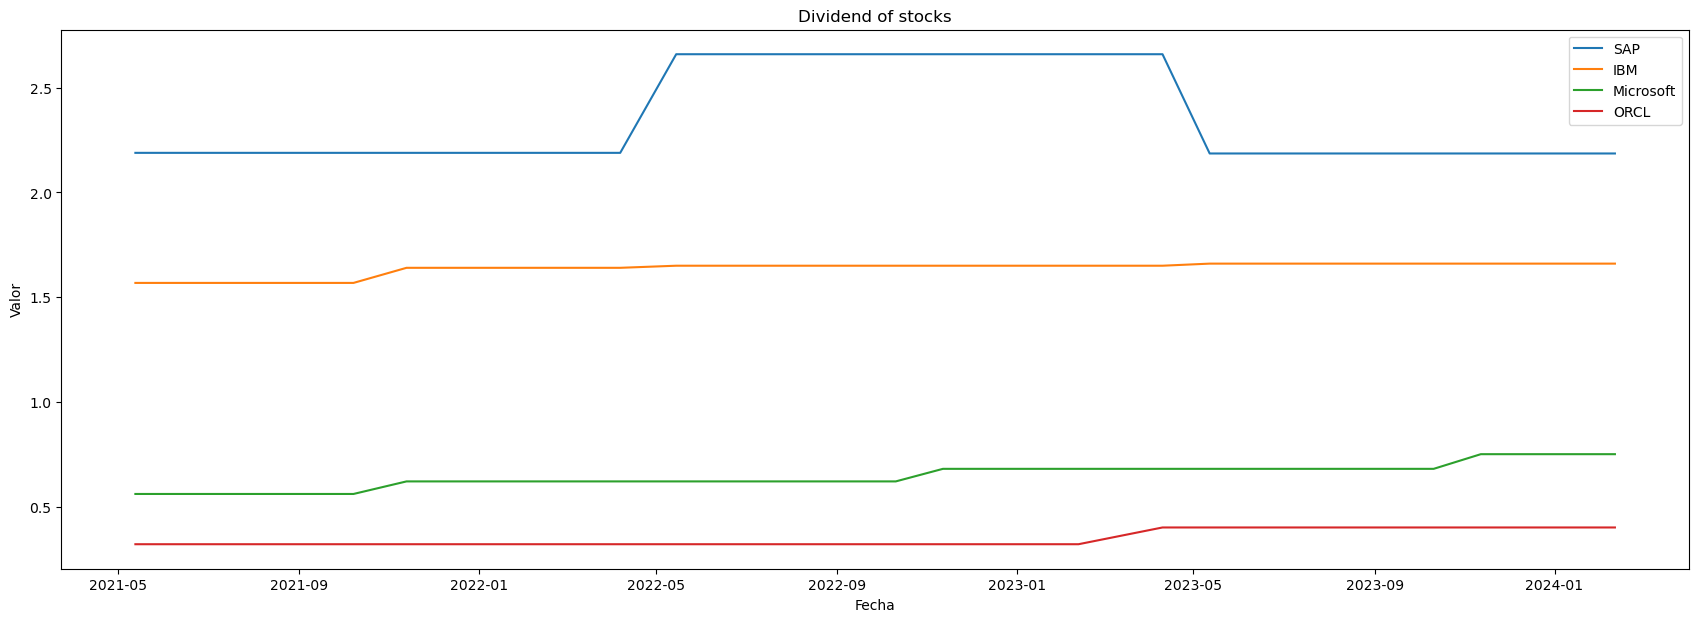

In [210]:
df_top6 = df_dividends.apply(lambda x: x.nlargest(6).index.tolist(), axis=1)[-1]
df_dividends = df_dividends.loc[:,df_top6]
# Graficar las líneas
plt.figure(figsize=(21, 7))
for column in df_dividends.columns:
    plt.plot(df_dividends.index, df_dividends[column], label=column)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Dividend of stocks')
plt.legend()
plt.show()

In [211]:
#SAP
#ORCL
#TSM
#QCOM
#AIR.PA
#PFE
#ARM
#Analisis de volumen de acciones